In [29]:
import torch
import pandas as pd
from torch import nn
from torchvision import transforms

from functools import partial

from collections import defaultdict



import re, math, sys
import numpy as np
import random

import os
from tqdm import tqdm

from PIL import Image
import importlib

from matplotlib import pyplot as plt

!pip3 install --upgrade transformers

import shap_functions

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


### Load data

In [2]:
stimuli_df = None
import utils
importlib.reload(utils)
stimuli_df = utils.STIMULI_DF

# add an extra "../" tot he data paths to create ../../VALSE_data
stimuli_df['img_path'] = [os.path.join("..",path) for path in stimuli_df['img_path']]

stimuli_df.head(2)


# import entire VALSE but only relevant linguistic phenomena
all_valse_df = utils.ENTIRE_DATASET_DF
all_valse_df = all_valse_df[all_valse_df['linguistic_phenomena'].isin(['actions','relations','existence'])]

# create 'img_path' column which has correct path to all the img files of valse dataset
all_valse_df['img_path'] = [os.path.join("../../VALSE_data/",path) for path in all_valse_df['local_img_path']]
all_valse_df.drop(['local_img_path'], axis=1)
all_valse_df.head(2)



/var/folders/3l/2lt99jp97mvbvsj3_p5hh8f80000gn/T/ipykernel_13310/1684243812.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_valse_df['img_path'] = [os.path.join("../../VALSE_data/",path) for path in all_valse_df['local_img_path']]


,dataset,dataset_idx,image_file,linguistic_phenomena,caption,answer,classes,split,original_split,classes_foil,...,key,declarative_statement,declarative_statement_foils,provenance_of_foils,foiling_method,orig_caption,only_caption,local_img_path,include_in_experiment,img_path
1000,coco2017,212732,000000462576.jpg,relations,Breakfast items including juice are on the table.,NaN,on,NaN,val,off,...,relations:coco_2017:212732,NaN,NaN,NaN,NaN,NaN,NaN,images/coco2017/000000462576.jpg,True,../../VALSE_data/images/coco2017/000000462576.jpg
1001,coco2017,528685,000000294162.jpg,relations,The white laptop is turned off but left open.,NaN,off,NaN,val,on,...,relations:coco_2017:528685,NaN,NaN,NaN,NaN,NaN,NaN,images/coco2017/000000294162.jpg,True,../../VALSE_data/images/coco2017/000000294162.jpg


# Setting up FLAVA

### Load model

In [6]:
global model

!pip3 install protobuf

from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

model_name = "SigLip"

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [7]:
processor

SiglipProcessor:
- image_processor: SiglipImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "SiglipImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "SiglipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

- tokenizer: SiglipTokenizer(name_or_path='google/siglip-base-patch16-224', vocab_size=32000, model_max_length=64, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1: AddedToken("</s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=True),
}

{
  "processor_class": "SiglipProcessor"
}

# Test model

Model card with helpful instructions: https://huggingface.co/facebook/flava-full

Caption: There is at least one bike on the rack.
Foil: There are no bikes on the rack.
Caption: There is at least one player shown.
Foil: There are no players shown.


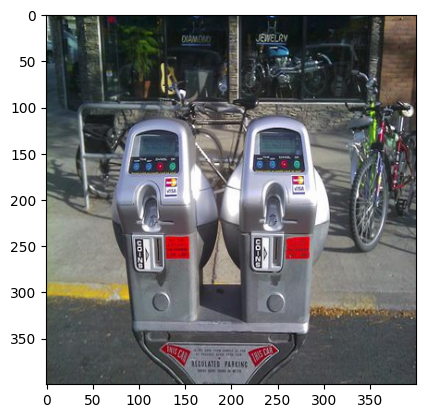

In [34]:
row = stimuli_df.iloc[7]
img_path1, caption1, foil1 = row['img_path'], row['caption'], row['foil']
image1 = Image.open(img_path1)

row = stimuli_df.iloc[8]
img_path2, caption2, foil2 = row['img_path'], row['caption'], row['foil']
image2 = Image.open(img_path2)

plt.imshow(image1)
print(f"Caption: {caption1}\nFoil: {foil1}")


plt.imshow(image1.resize((400,400)))
print(f"Caption: {caption2}\nFoil: {foil2}")

**Make sure it can take multiple images at once**

In [35]:

images = [image1, image2]
text = [caption1, foil1, caption1, foil1] # we repeat the same caption and foil across each

with torch.no_grad():

    # encode text and image input together for caption and foil for potentially multiple images
    inputs = processor(text=[caption1, foil1], images=images, padding="max_length", return_tensors="pt")

    output = model(**inputs)

output.logits_per_image


 

tensor([[ -4.9801,  -4.7209],
        [-15.6008, -14.2705]])

# Run on data

### Define model prediction function (for SHAP -- taking list of images and caption/foil as input)

In [21]:
text_out = []


def model_predict(images, caption, foil, single_image = False, single_score = True, verbose = False):
    """Needs CAPTION and FOIL to be defined outside the function,
    caption and foil kept constant within the function for each image

    images needs to be a LIST, even if only one member. PIL image format


    single score = True for SHAP! (this means one number returned for each image)
    single_image = False for SHAP! (single_image means only one value or set of values is returned, assuming there is 1 image only)
    """

    global model

    with torch.no_grad():

        # encode text and image input together for caption and foil for potentially multiple images
        inputs = processor(text=[caption, foil], images=images, padding="max_length", return_tensors="pt")

        output = model(**inputs)

        scores = output.logits_per_image

    # if want single score per image, use caption score minus foil score
    if single_score:
        scores = scores[:, 0] - scores[:, 1]  

    # if single image, return the first element of the list
    if single_image:
        return scores[0]
    else: # otherwise return a list
        return scores

# test on above example
print("Score for each caption-image pair for two images:", model_predict([image1, image2], caption1, foil1, single_image = False, single_score = False, verbose=True))
print("Caption foil score DIFFERENCE for two images:", model_predict([image1, image2], caption1, foil1, single_image = False, single_score = True))



Score for each caption-image pair for two images: tensor([[ -4.9801,  -4.7209],
        [-15.6008, -14.2705]])
Caption foil score DIFFERENCE for two images: tensor([-0.2593, -1.3303])


### Define model output caption for dataframes (taking dataframe as input)

Difference: the SHAP prediction function works with a list of images for a single set of captions. 

This one works with a dataframe where each SINGLE image is paired with one caption/foil and an output generated.

In [22]:
def model_output_dataframe(df):
    
    """Given a dataframe of images, captions, and foils, returns a dataframe of model outputs, one for each row in the dataframe"""

    results = defaultdict(list)

    for _, row in tqdm(df.iterrows()):

        # copy over those things that should be copied directly
        for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
            results[name].append(row[name])

        # prepare data point as inputs to test model on
        image = Image.open(row["img_path"]).convert('RGB')

        caption, foil = row["caption"], row["foil"]
        
        
        # create model input with BOTH captions
        try:
            model_results = model_predict([image], caption, foil, single_image = True, single_score = False)
        except Exception as e:
            print(f"Trouble processing {row['img_path']}")
            print(e)
            continue
        
        caption_score, foil_score = model_results[0].item(), model_results[1].item()
        caption_foil_diff = caption_score - foil_score
        
        # save relevant fields to the dictionary to either {caption} or {foil} (based on which it is)
        results["model_pred_caption"].append(caption_score) # logit
        results["model_pred_foil"].append(foil_score)
        results["model_pred_diff"].append(caption_foil_diff)

    print(results)

    
    model_output = pd.DataFrame.from_dict(results)


    return model_output

### Generate model output for each data point in STIMULI dataframe (without maskng)

99it [00:40,  2.45it/s]

defaultdict(<class 'list'>, {'img_path': ['../../VALSE_data/images/v7w/v7w_2318073.jpg', '../../VALSE_data/images/v7w/v7w_2323857.jpg', '../../VALSE_data/images/v7w/v7w_2336798.jpg', '../../VALSE_data/images/v7w/v7w_2349587.jpg', '../../VALSE_data/images/v7w/v7w_2352298.jpg', '../../VALSE_data/images/v7w/v7w_2360434.jpg', '../../VALSE_data/images/v7w/v7w_2362476.jpg', '../../VALSE_data/images/v7w/v7w_2389519.jpg', '../../VALSE_data/images/v7w/v7w_2393355.jpg', '../../VALSE_data/images/v7w/v7w_2411942.jpg', '../../VALSE_data/images/v7w/v7w_2417412.jpg', '../../VALSE_data/images/swig/speaking_84.jpg', '../../VALSE_data/images/swig/tripping_125.jpg', '../../VALSE_data/images/swig/punching_28.jpg', '../../VALSE_data/images/swig/handcuffing_40.jpg', '../../VALSE_data/images/swig/caressing_51.jpg', '../../VALSE_data/images/swig/urinating_251.jpg', '../../VALSE_data/images/swig/foraging_17.jpg', '../../VALSE_data/images/swig/communicating_34.jpg', '../../VALSE_data/images/swig/complaining_6.j

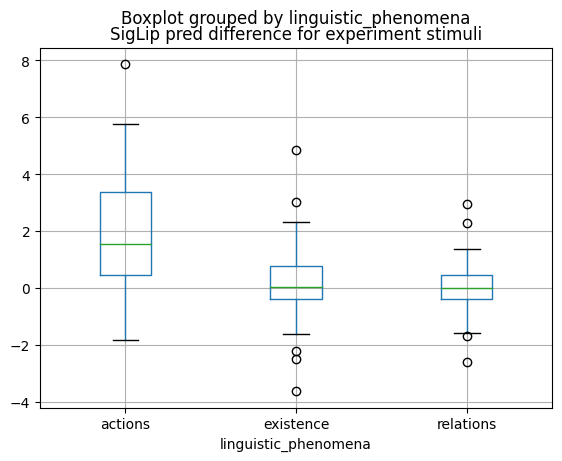

In [24]:

stimuli_output_df = model_output_dataframe(stimuli_df)

# export results
stimuli_output_df.to_pickle(f"xai_output/{model_name}_stimuli_output_scores.pickle")

# graph outcome
stimuli_output_df.boxplot(column='model_pred_diff', by='linguistic_phenomena')
plt.title(f"{model_name} pred difference for experiment stimuli")
plt.show()


### Generate model output for ENTIRE VALSE DATASET for 3 linguistic phenomena

Assuming  only for 3 phenomena

2637it [16:00,  2.75it/s]

defaultdict(<class 'list'>, {'img_path': ['../../VALSE_data/images/coco2017/000000462576.jpg', '../../VALSE_data/images/coco2017/000000294162.jpg', '../../VALSE_data/images/coco2017/000000144333.jpg', '../../VALSE_data/images/coco2017/000000181666.jpg', '../../VALSE_data/images/coco2017/000000482436.jpg', '../../VALSE_data/images/coco2017/000000153299.jpg', '../../VALSE_data/images/coco2017/000000337055.jpg', '../../VALSE_data/images/coco2017/000000526728.jpg', '../../VALSE_data/images/coco2017/000000402519.jpg', '../../VALSE_data/images/coco2017/000000490413.jpg', '../../VALSE_data/images/coco2017/000000178618.jpg', '../../VALSE_data/images/coco2017/000000140286.jpg', '../../VALSE_data/images/coco2017/000000033368.jpg', '../../VALSE_data/images/coco2017/000000034760.jpg', '../../VALSE_data/images/coco2017/000000320554.jpg', '../../VALSE_data/images/coco2017/000000141671.jpg', '../../VALSE_data/images/coco2017/000000068628.jpg', '../../VALSE_data/images/coco2017/000000003255.jpg', '../

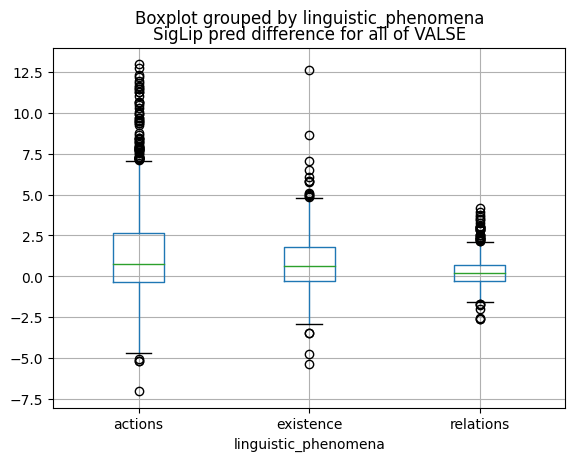

In [25]:
RUN_ON_WHOLE_DATASET = False # can be turned off when we don't need this

if RUN_ON_WHOLE_DATASET:

    valse_output_df = model_output_dataframe(all_valse_df)

    # export results
    valse_output_df.to_pickle(f"xai_output/{model_name}_all_of_valse_output_scores.pickle")

    # graph outcome
    valse_output_df.boxplot(column='model_pred_diff', by='linguistic_phenomena')
    plt.title(f"{model_name} pred difference for all of VALSE")
    plt.show()

## Build SHAP pipeline

### Masking functions

In [ ]:
from shap_functions import vector_to_masked_images, blur_image


### Test masking

In [ ]:
# image = Image.open("../../VALSE_data/images/coco2017/000000122672.jpg")
# image = np.array(image.resize((224,224)))

# blurred_image = blur_image(image)

# test_mask_array = np.array([
#     [1, 0, 0, 1],
#     [0, 1, 1, 0],
#     [1, 0, 0, 0],
#     [0, 0, 1, 0]
# ])

# masked_img = vector_to_masked_images([test_mask_array], image, blurred_image, N_ROWS=4)[0]
# plt.imshow(masked_img)

### SHAP function

In [30]:
import shap_functions
importlib.reload(shap_functions)

<module 'shap_functions' from '/Users/eduardsaakashvili/Desktop/UU/Thesis/code/es-thesis-repo/data/xai_maps/shap_functions.py'>

# Generate and export SHAP maps

### Generate maps (in smaller batchs)

In [ ]:
import pandas as pd
from collections import defaultdict
import os

VERBOSE = 1 
DISPLAY_PLOTS = False
EXPORT_PLOTS = True
CHUNK_SIZE = 11  # nr of rows to process at a time
START_INDEX = 0  # default start index is 0

output = defaultdict(list)

# find total number of chunks needed
total_rows = len(stimuli_df)
num_chunks = (total_rows - START_INDEX) // CHUNK_SIZE + ((total_rows - START_INDEX) % CHUNK_SIZE > 0)

all_dfs = []  # list to store each chunk's DF

# loop through DF one chunk at a time
for chunk_start in range(START_INDEX, total_rows, CHUNK_SIZE):
    chunk_end = min(chunk_start + CHUNK_SIZE, total_rows)
    print(f"Processing rows {chunk_start} to {chunk_end} out of {total_rows}")

    # chunk output is a separate list
    chunk_output = defaultdict(list)

    # iterate through rows in chunk
    for index, row in stimuli_df.iloc[chunk_start:chunk_end].iterrows():
        print(f"Processing stimulus {index + 1} out of {total_rows}")

        # Copy main characteristics
        for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
            chunk_output[name].append(row[name])

        # Calculate shap map
        try:
            shap_map, n_variants = shap_functions.generate_shap(row['img_path'], row['caption'], row['foil'],
                                                                prediction_function=model_predict,
                                                                model=model,
                                                                model_name=model_name,
                                                                verbose=VERBOSE,
                                                                plots=DISPLAY_PLOTS,
                                                                export_plots=EXPORT_PLOTS,
                                                                return_variant_count=True)
            chunk_output["model_shap_map"].append(shap_map)
            chunk_output['n_image_variants'].append(n_variants)

        except Exception as e:
            chunk_output['model_shap_map'].append(f"Error: {str(e)}")
            chunk_output['n_image_variants'].append("Error")

            print(e)

    # convert the chunk output to a DF and save it
    chunk_df = pd.DataFrame.from_dict(chunk_output)
    chunk_df.to_pickle(f"xai_output/{model_name}_shap_maps_chunk_{chunk_start//CHUNK_SIZE}.pickle")



In [32]:
# merge all chunk outputs into one

# open aeach chunk DF, into a list
all_dfs = [pd.read_pickle(os.path.join("xai_output", filename)) for filename in os.listdir("xai_output") if "chunk" in filename and model_name in filename]

# merge all the lists
final_model_shap_df = pd.concat(all_dfs, ignore_index=True)
final_model_shap_df.to_pickle(f"xai_output/{model_name}_shap_maps.pickle")

In [7]:
# for key in output.keys():
#     print(key, len(output[key]))

### Export resulting dataframe

In [23]:
final_model_shap_df.to_pickle(f"xai_output/{model_name}_shap_maps.pickle")

### Find which if any stimuli threw an error

In [24]:
final_model_shap_df[final_model_shap_df['model_shap_map'].apply(isinstance, args=(str,))]

,img_path,caption,foil,linguistic_phenomena,model_shap_map,n_image_variants


In [ ]:
plt.imshow(final_clip_shap_df['clip_shap_map'][0])

NameError: name 'final_clip_shap_df' is not defined